In [1]:
!pip3 install pandas
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import torch.nn.init as init

from lib.layers import *
from lib.utils.timer import Timer
from lib.utils.data_augment import preproc
from lib.modeling.model_builder import create_model
from lib.modeling.discriminator.DNet import D_Net
from lib.dataset.dataset_factory import load_data
from lib.utils.config_parse_mimic_MOB_in_MOB import cfg
from lib.utils.config_parse_mimic_VOC_COCO_ZERO import cfg1
# from lib.utils.config_parse_mimic_VOC_COCO_LR_ARD import cfg
from lib.utils.eval_utils import *
from lib.utils.visualize_utils import *

    100% |################################| 10.0MB 102kB/s ta 0:00:01
    100% |################################| 512kB 1.2MB/s ta 0:00:011


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100.0%


ImportError: cannot import name 'cfg1'

In [1]:
def f(n):
    if n==1 or n==0:
        return 1
    else: 
        return n*f(n-1)

In [3]:
a= f

In [4]:
a(5)

120

In [191]:
test_loader = load_data(cfg.DATASET, 'correlation') if 'test' in cfg.PHASE1 else None
data_iterator = iter(test_loader)
NUM_IMAGE = -1

In [192]:
model_student, priorbox = create_model(cfg.MODEL)
model_student.load_state_dict(
    torch.load('./Weights/MobileNet2_Medium_Ones_VOC/ssd_lite_mobilenet_v2_voc_epoch_278_MAX_70.7.pth'))
priors = Variable(priorbox.forward(), volatile=True)
detector = Detect(cfg.POST_PROCESS, priors.cpu())

==>Feature map size:
[(19, 19), (10, 10), (5, 5), (3, 3), (2, 2), (1, 1)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


In [193]:
model_teacher = create_model(cfg.MODEL_MIMIC)
model_teacher.load_state_dict(
    torch.load('./Weights/Original_V3_VOC/ssd_lite_mobilenet_v2_voc_epoch_266_MAX_69.5.pth'))

==>Feature map size:
[(19, 19), (10, 10), (5, 5), (3, 3), (2, 2), (1, 1)]


<All keys matched successfully>

In [194]:
POS = MultiBoxLoss(cfg.MATCHER, priors, True)
model_student.eval().cuda()
model_teacher.eval().cuda()
print('Sucsessful')

Sucsessful


In [198]:
images, targets = next(data_iterator)
NUM_IMAGE += 1
images = Variable(images.cuda())
targets = [Variable(anno.cuda(), volatile=True) for anno in targets]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


In [199]:
dataset = test_loader.dataset
img = dataset.pull_image(NUM_IMAGE)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

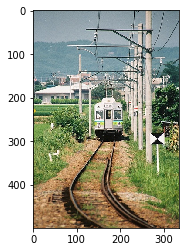

In [200]:
# rgb_image = cv2.cvtColor(images.cpu().squeeze(0).permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB)
scale = torch.tensor([rgb_image.shape[1], rgb_image.shape[0], rgb_image.shape[1], rgb_image.shape[0]], dtype=torch.float)
plt.imshow(rgb_image)

In [201]:
targets[0].size(1)

5

tensor(7.)


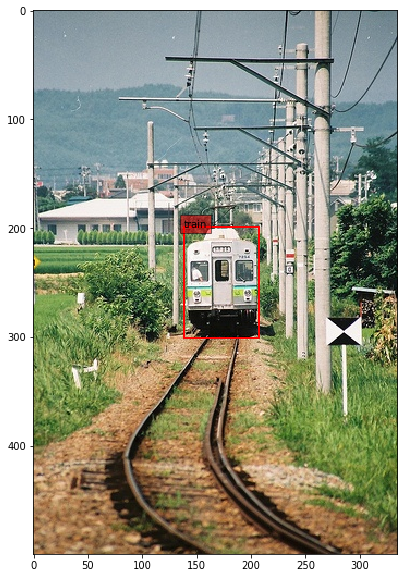

In [202]:
plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
# labels = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',\
#           'boat', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'bottle', 'chair',\
#           'couch', 'potted plant', 'dining table', 'tv']
labels = (  # always index 0
    'person', 'bicycle', 'car', 'motorbike',
    'aeroplane', 'bus', 'train', 'boat', 'bird',
    'cat', 'dog', 'horse', 'sheep',
    'cow', 'bottle', 'chair',
    'sofa', 'pottedplant', 'diningtable', 'tvmonitor')

for i in range(targets[0].size(0)):
    print(targets[0][i,4])
    j = 0
    label_name = labels[targets[0][i,4].long()-1]
    display_txt = '%s'%(label_name)
    pt = (targets[0][i,:4]*scale).cpu().numpy()
    coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
#         print(label_name)
#         print(score)
    color = colors[i]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
    j+=1

In [203]:
out_student, FM_student = model_student(images, phase='train_mimic')
print(out_student[0].size())
print(out_student[1].size())
loss1, loss2, pos = POS(out_student, targets, 'train_mimic')
FM_teacher = model_teacher(images, phase='feature')

torch.Size([1, 2990, 4])
torch.Size([1, 2990, 21])


In [208]:
inputs = FM_student[0]
maper = pos[:,0:19*19].float()
answer = maper.view(inputs.size(0),sizes[i],-1).sum(dim=-1)>0
print(answer.size())
inputs = inputs.view(inputs.size(0),-1,inputs.size(1))
print(inputs.size())
inputs = inputs[answer]
print(inputs.size())

torch.Size([1, 361])
torch.Size([1, 361, 512])
torch.Size([0, 512])


In [168]:
pos.squeeze(0).size()

torch.Size([2990])

In [169]:
priors[pos.squeeze(0)].size()

torch.Size([14, 4])

[ 94.13334 293.3333  105.9     150.     ]
[ 94.13334 293.3333  129.70049 183.71173]
[ 94.13334 293.3333  149.76521 106.06602]
[ 94.13334 293.3333  183.42418  86.60254]
[131.78667 293.3333  105.9     150.     ]
[131.78667 293.3333  129.70049 183.71173]
[131.78667 293.3333  149.76521 106.06602]
[131.78667 293.3333  183.42418  86.60254]
[131.78667 346.66666 129.70049 183.71173]
[112.96    266.6667  158.84999 225.     ]
[176.5     250.      317.69998 450.     ]
[176.5     250.      343.1552  486.05554]
[176.5     250.      353.      318.19806]
[176.5     250.      224.64783 500.     ]


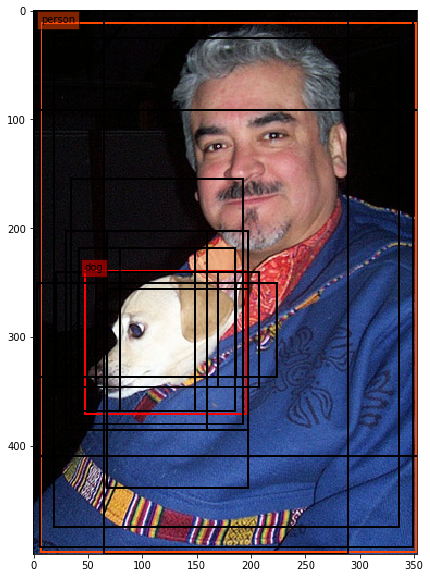

In [170]:
plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
# labels = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',\
#           'boat', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'bottle', 'chair',\
#           'couch', 'potted plant', 'dining table', 'tv']
labels = (  # always index 0
    'person', 'bicycle', 'car', 'motorbike',
    'aeroplane', 'bus', 'train', 'boat', 'bird',
    'cat', 'dog', 'horse', 'sheep',
    'cow', 'bottle', 'chair',
    'sofa', 'pottedplant', 'diningtable', 'tvmonitor')
boxes = priors[pos.squeeze(0)]
for i in range(targets[0].size(0)):
#     print(targets[0][i,4])
    j = 0
    label_name = labels[targets[0][i,4].long()-1]
    display_txt = '%s'%(label_name)
    pt = (targets[0][i,:4]*scale).cpu().numpy()
    coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
#         print(label_name)
#         print(score)
    color = colors[i]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
    j+=1
for i in range(boxes.size(0)):
    j = 0
    pt = (boxes[i]*scale).cpu().numpy()
    print(pt)
    coords = (pt[0]- pt[2]//2, pt[1]- pt[3]//2), pt[2], pt[3]
#         print(label_name)
#         print(score)
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, linewidth=2))
    j+=1

In [183]:
test_loader = load_data(cfg.DATASET, 'train') if 'test' in cfg.PHASE1 else None

In [185]:
sizes = [361, 100, 25, 9, 4, 1]
boxes = [6, 6, 6, 6, 4, 4]
fm = [0 for i in range(6)]
err = [0 for i in range(6)]
for images, targets in test_loader:
    targets = [Variable(anno.cuda(), volatile=True) for anno in targets]
    loss1, loss2, pos = POS(out_student, targets, 'train_mimic')
    
    start = 0
    end = 0
    for i in range(6):
        start += sizes[i]*boxes[i]
        a = sum(pos[0,end:start].float()).item()
        fm[i] += a
        if a>0:
            err[i] += 1
        end = start
print(fm)
print(err)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


[1856.0, 1652.0, 779.0, 522.0, 122.0, 472.0]
[270, 250, 191, 179, 57, 145]


In [228]:
import os
a = os.listdir('./Weights/DarkNet53_D1Linear_Ones_VOC/')
# print(a)
for i in range(1,100):
#     print('Correlation_'+str(i))
    if not 'Correlation_'+str(i)+'.txt' in a:
        print(i)
        break

2


In [10]:
unfold = nn.Unfold(kernel_size=(3, 3))
input = torch.randn(2, 1, 4, 4)
print(input)
output = unfold(input)
# each patch contains 30 values (2x3=6 vectors, each of 5 channels)
# 4 blocks (2x3 kernels) in total in the 3x4 input
print(output.size())
output

tensor([[[[-1.9761,  0.8815,  0.5631,  0.3116],
          [-1.4131, -0.1447, -0.5997, -0.2969],
          [ 0.2336, -2.0942,  1.3229, -0.0567],
          [-0.5847,  1.6088, -0.5291,  1.3431]]],


        [[[ 0.0021, -0.7341,  2.0124,  0.0026],
          [ 1.2602, -0.0987,  0.8158, -1.2170],
          [-0.1629, -0.8511, -0.9298, -0.4634],
          [-1.1193, -0.3110, -0.6889,  1.4304]]]])
torch.Size([2, 9, 4])


tensor([[[-1.9761,  0.8815, -1.4131, -0.1447],
         [ 0.8815,  0.5631, -0.1447, -0.5997],
         [ 0.5631,  0.3116, -0.5997, -0.2969],
         [-1.4131, -0.1447,  0.2336, -2.0942],
         [-0.1447, -0.5997, -2.0942,  1.3229],
         [-0.5997, -0.2969,  1.3229, -0.0567],
         [ 0.2336, -2.0942, -0.5847,  1.6088],
         [-2.0942,  1.3229,  1.6088, -0.5291],
         [ 1.3229, -0.0567, -0.5291,  1.3431]],

        [[ 0.0021, -0.7341,  1.2602, -0.0987],
         [-0.7341,  2.0124, -0.0987,  0.8158],
         [ 2.0124,  0.0026,  0.8158, -1.2170],
         [ 1.2602, -0.0987, -0.1629, -0.8511],
         [-0.0987,  0.8158, -0.8511, -0.9298],
         [ 0.8158, -1.2170, -0.9298, -0.4634],
         [-0.1629, -0.8511, -1.1193, -0.3110],
         [-0.8511, -0.9298, -0.3110, -0.6889],
         [-0.9298, -0.4634, -0.6889,  1.4304]]])

In [30]:
y = torch.ones(1,2,1,1,3,1)
z = torch.rand(1,2,1,1,1,3)
x = torch.rand(1,2,3,3)
print(x)
x = x.unfold(2,3,1)
print(x.size())
x = x.unfold(3,3,1)
print(x.size())
print(x)
print('================')
print(x[:,0]+y)
print('================')
print(x[:,1]+z)

tensor([[[[1.2438e-01, 4.8871e-01, 2.2908e-04],
          [5.2684e-01, 2.3187e-01, 5.6780e-01],
          [9.7565e-01, 2.9455e-01, 3.8494e-01]],

         [[5.7631e-01, 5.1312e-01, 4.1027e-01],
          [4.9188e-02, 3.9361e-01, 8.1734e-02],
          [7.8417e-01, 4.7450e-01, 3.1325e-01]]]])
torch.Size([1, 2, 1, 3, 3])
torch.Size([1, 2, 1, 1, 3, 3])
tensor([[[[[[1.2438e-01, 4.8871e-01, 2.2908e-04],
            [5.2684e-01, 2.3187e-01, 5.6780e-01],
            [9.7565e-01, 2.9455e-01, 3.8494e-01]]]],



         [[[[5.7631e-01, 5.1312e-01, 4.1027e-01],
            [4.9188e-02, 3.9361e-01, 8.1734e-02],
            [7.8417e-01, 4.7450e-01, 3.1325e-01]]]]]])
tensor([[[[[[1.1244, 1.4887, 1.0002],
            [1.5268, 1.2319, 1.5678],
            [1.9757, 1.2946, 1.3849]]]],



         [[[[1.1244, 1.4887, 1.0002],
            [1.5268, 1.2319, 1.5678],
            [1.9757, 1.2946, 1.3849]]]]]])
tensor([[[[[[1.3121, 1.0916, 1.0725],
            [0.7850, 0.9721, 0.7440],
            [1.5199, 1

In [33]:
x = torch.rand(1,1,1,3,3,2)
print(x)
q = torch.rand(1,1,1,3,3,1)
print(q)
print((q*x).size())
q*x


tensor([[[[[[0.4534, 0.7743],
            [0.8922, 0.0143],
            [0.4653, 0.7286]],

           [[0.3616, 0.9596],
            [0.8231, 0.6582],
            [0.1613, 0.8372]],

           [[0.1718, 0.8696],
            [0.6026, 0.4988],
            [0.4439, 0.8078]]]]]])
tensor([[[[[[0.2996],
            [0.5333],
            [0.0589]],

           [[0.4130],
            [0.1993],
            [0.5859]],

           [[0.4987],
            [0.5292],
            [0.5011]]]]]])
torch.Size([1, 1, 1, 3, 3, 2])


tensor([[[[[[0.1358, 0.2320],
            [0.4758, 0.0076],
            [0.0274, 0.0429]],

           [[0.1493, 0.3963],
            [0.1641, 0.1312],
            [0.0945, 0.4905]],

           [[0.0857, 0.4336],
            [0.3189, 0.2639],
            [0.2224, 0.4048]]]]]])

In [34]:
0.4534*0.2996

0.13583864

In [39]:
x = torch.rand(1,2,1,2,2,1)
print(x)
y = torch.rand(1,2,1,2,2,1)
print(y)
torch.einsum('bnchwk,bnchwk -> bnchw', x, y)

tensor([[[[[[0.6147],
            [0.2902]],

           [[0.8318],
            [0.3807]]]],



         [[[[0.3266],
            [0.9013]],

           [[0.6725],
            [0.4898]]]]]])
tensor([[[[[[0.8834],
            [0.8007]],

           [[0.7184],
            [0.9643]]]],



         [[[[0.7431],
            [0.4468]],

           [[0.1632],
            [0.0815]]]]]])


tensor([[[[[0.5430, 0.2324],
           [0.5976, 0.3671]]],


         [[[0.2427, 0.4027],
           [0.1098, 0.0399]]]]])

In [41]:
0.2324 /0.8007

0.29024603471962035